In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import k_clique_communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import itertools
import numpy as np
import infomap
from infomap import Infomap
from utils import *

# LFR Graph community detection. 
#####  Import LFR benchmark network “Benchmark graphs for testing community detection algorithms”, Andrea Lancichinetti, Santo Fortunato, and Filippo Radicchi, Phys. Rev. E 78, 046110 2008


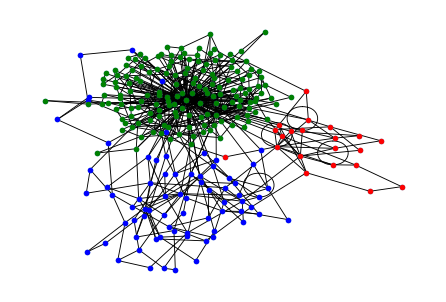

The ground truth modularity is 0.376


In [2]:
n = 250 # Number of nodes in the created graph.
tau1 = 3 # Power law exponent for the degree distribution of the created graph. 
tau2 = 1.5 # Power law exponent for the community size distribution in the created graph.
mu = 0.1 # Fraction of inter-community edges incident to each node. 

G = nx.LFR_benchmark_graph( n, tau1, tau2, mu, average_degree=5, min_community=20, seed=10) 
# Get ground truth communities
communities = list({frozenset(G.nodes[v]["community"]) for v in G})
presentCommunities(G,communities)
# Use modularity to check partition
ground_truth_mod = nx_comm.modularity(G,communities)
print(f"The ground truth modularity is {ground_truth_mod:.3}")

# Girvan Newman 
##### Invesitigate how modularity changes as more disconections are made and more communities are found

In [3]:
%%time
# Algorithm 1. Girvan Newman 
partition_girvan_newman = girvan_newman(G)
k = 40 # Check 39 partitions

mod_list = []
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)
    # Use modularity to check partition
    GN_mod = nx_comm.modularity(G,partitions)
    mod_list.append(GN_mod)

# plot partitions with k to optimize modularity
plt.plot(mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Girvvan Newman modularity against number of communities")
plt.show()

##### Check modularity with apriori knowledge of 3 communities from the ground truth

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


([0, 1, 2, 4, 5, 6, 9, 10, 11, 15, 17, 25, 26, 30, 32, 35, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 56, 57, 59, 60, 62, 64, 66, 67, 68, 71, 73, 74, 77, 79, 81, 84, 86, 87, 88, 89, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 107, 108, 109, 110, 111, 112, 113, 115, 116, 119, 120, 123, 126, 128, 130, 131, 132, 135, 137, 138, 139, 140, 141, 143, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 159, 160, 163, 164, 165, 166, 170, 171, 172, 174, 176, 177, 179, 181, 183, 185, 186, 187, 188, 189, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 217, 218, 220, 221, 222, 223, 227, 228, 230, 231, 232, 233, 234, 235, 236, 238, 240, 241, 242, 243, 244, 245], [3, 7, 13, 14, 20, 23, 24, 27, 28, 29, 31, 36, 37, 39, 40, 46, 54, 55, 58, 63, 65, 69, 72, 75, 76, 78, 82, 83, 85, 90, 93, 105, 106, 114, 117, 118, 122, 124, 125, 127, 129, 133, 134, 136, 142, 144, 153, 158, 162, 167, 168, 169, 173, 175, 178, 180, 182, 184, 190, 193, 203, 

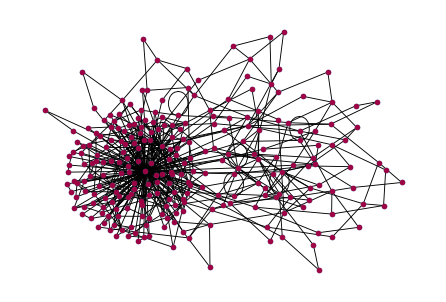

CPU times: user 5.51 s, sys: 69.6 ms, total: 5.58 s
Wall time: 5.37 s


In [5]:
%%time 
partition_girvan_newman = girvan_newman(G)
k=2 # if we have apriori knowledge of 3 groudn truth communities:
for communities in itertools.islice(partition_girvan_newman, k):
    partitions = tuple(sorted(c) for c in communities)

print(partitions)

GN_mod = nx_comm.modularity(G,partitions)
print(f"{len(partitions)} communities detected")
print(f"The modularity is {GN_mod:.3}")
presentCommunities(G,partitions)

# Infomap
#####  https://github.com/mapequation/infomap

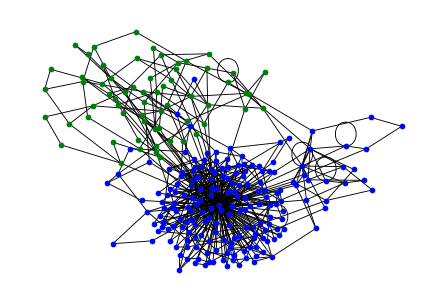

2 communities detected
The modularity is 0.26
CPU times: user 396 ms, sys: 60.1 ms, total: 456 ms
Wall time: 186 ms


In [5]:
%%time
# Algorithm 2. k infomap

im = Infomap(silent=True)
im.add_networkx_graph(G)
im.run()

partition = [[] for _ in range(im.num_top_modules)]
for node in im.tree:
    if node.is_leaf:
        partition[node.module_id-1].append(node.node_id)

# Need to decide when to stop removing edges.
presentCommunities(G,partition)

info_mod = nx_comm.modularity(G,tuple(partition))
print(f"{len(partition)} communities detected")
print(f"The modularity is {info_mod:.3}")

# Spectral Clustering

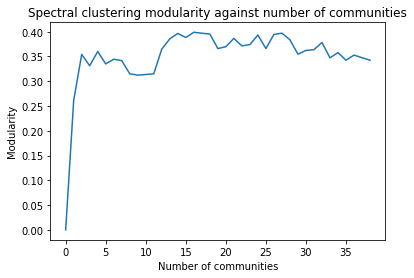

CPU times: user 1min 20s, sys: 52.1 s, total: 2min 12s
Wall time: 27.8 s


In [6]:
%%time
# Algorithm 3. Spectral clustering

# Get adjacency-matrix as numpy-array
sc_mod_list = []
for k in range(1,40):
    adj_mat = nx.to_numpy_matrix(G)
    # Cluster
    sc = SpectralClustering(k, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    partition_labels = sc.labels_.tolist()
    # Turn back into partition data structure ([],[],[]...)
    # position in list is node number value is community id

    partition = [[] for _ in range(max(partition_labels)+1)]
    for idx,c in enumerate(partition_labels):
        partition[c].append(idx)

    sc_mod = nx_comm.modularity(G,tuple(partition))
    sc_mod_list.append(sc_mod)

# Plot modularity for increasing community number
plt.plot(sc_mod_list)
plt.xlabel("Number of communities")
plt.ylabel("Modularity")
plt.title("Spectral clustering modularity against number of communities")
plt.show()

##### With apriori knowledge of ground truth community number k = 3

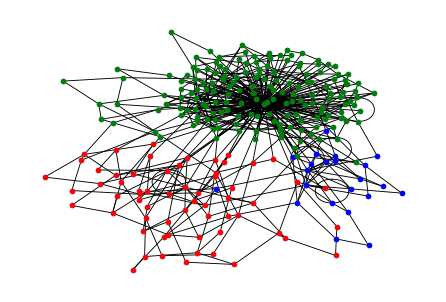

3 communities detected
The modularity is 0.354
CPU times: user 687 ms, sys: 330 ms, total: 1.02 s
Wall time: 343 ms


In [7]:
%%time
k=3
# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G)
# Cluster
sc = SpectralClustering(k, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

partition_labels = sc.labels_.tolist()
# Turn back into partition data structure ([],[],[]...)
# position in list is node number value is community id

partition = [[] for _ in range(max(partition_labels)+1)]
for idx,c in enumerate(partition_labels):
    partition[c].append(idx)

# Need to decide when to stop removing edges.
presentCommunities(G,partition)

sc_mod = nx_comm.modularity(G,tuple(partition))
print(f"{len(partition)} communities detected")
print(f"The modularity is {sc_mod:.3}")

# Analysis

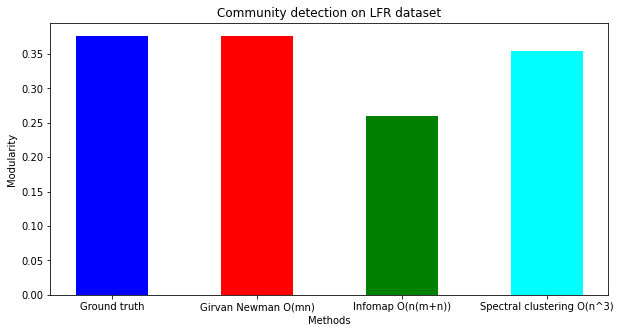

In [8]:
# Compare methods
data = {'Ground truth':ground_truth_mod, 'Girvan Newman O(mn)':GN_mod, 'Infomap O(n(m+n))':info_mod,
        'Spectral clustering O(n^3)':sc_mod}
method = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, values,
        width = 0.5, color=['blue', 'red', 'green', 'cyan'])
 
plt.xlabel("Methods")
plt.ylabel("Modularity")
plt.title("Community detection on LFR dataset")
plt.show()